## Import Packages

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import parser
from datetime import datetime,timedelta
import statsmodels.api as sm
from pytrends.request import TrendReq




## Setup
Because of the environment difference, when using selenium, you may meet some errors, to avoid this, you could set the varibale `data_source` to `local` or `remote`.
If you want to use the local data, you can set the variable `data_source` to `local` to avoid the error. If your want to run the scraping code, you could set the variable `data_source` to `remote`.
Default setting is `local`.

In [54]:
data_source = 'local'

# Analyze the reaction of Dogecoin price 10 mins after Elon Musk tweeted about it
## Get Twitter Data from Twitter


In [55]:
# Because Twitter API has some limitations, we need to crawl the tweets.
# We encapsulate the TwitterScaper class to get the tweets and save the data to 'data/dogecoin_tweets.csv'
from utils import TwitterScaper 
if data_source == 'local':
    pass
elif data_source == 'remote':
    print('Starting Scrape...')
    ts = TwitterScaper(headless=False)
    to_parse = ts.scrape_tweets()
    scraped_data = ts.parse_tweets(to_parse)
    print('Scrape Success!')
    scraped_data.to_csv('data/dogecoin_tweets.csv', index=False)


## Get Dogecoin price data from ccxt

In [56]:
# We encapsulate the TwitterScaper class to get the price data and save the data to 'data/dogecoin_price.csv'
from utils import PriceGetter
duration = 0.25 #hours
interval  = 1 # minute
price = PriceGetter(timeframe=f"{interval}m")

tweets_df = pd.read_csv('data/dogecoin_tweets.csv')

# deal with the daylight saving time 
for ind,row in tweets_df.iterrows():
    if 10>=parser.parse(row["timestamp"]).month >=4:
        tweets_df.loc[ind,"timestamp"] = parser.parse(tweets_df.loc[ind,"timestamp"])-timedelta(hours=1)

tweets_df['timestamp'] = pd.to_datetime(tweets_df['timestamp'])#.apply(lambda x:datetime.strftime(x,'%Y-%m-%d %H:00:00'))



date = tweets_df["timestamp"]
for ind,d in enumerate(date):
    # if 4<=parser.parse(d).month<=10:
    #     timestamp = int(parser.parse(d).timestamp()-3600*(duration-1)) * 1000 # daylight saving time is one hour earlier than winter time
    # else:
    #     timestamp = int(parser.parse(d).timestamp() - 3600*duration) * 1000
    timestamp = int(d.timestamp() - 3600*duration) * 1000
    price.update_price(since=timestamp, limit=int(duration*120/interval))
    print(f"Finished {ind+1} of {len(date)}")
price.rename_col()
price.drop_duplicates()
price.rank_data()
price.save_price(f"price_clean_{duration}h.csv")


Finished 1 of 26
Finished 2 of 26
Finished 3 of 26
Finished 4 of 26
Finished 5 of 26
Finished 6 of 26
Finished 7 of 26
Finished 8 of 26
Finished 9 of 26
Finished 10 of 26
Finished 11 of 26
Finished 12 of 26
Finished 13 of 26
Finished 14 of 26
Finished 15 of 26
Finished 16 of 26
Finished 17 of 26
Finished 18 of 26
Finished 19 of 26
Finished 20 of 26
Finished 21 of 26
Finished 22 of 26
Finished 23 of 26
Finished 24 of 26
Finished 25 of 26
Finished 26 of 26


## Preprocess data


In [57]:
dogecoin_price_df = pd.read_csv(f'data/price_clean_{duration}h.csv')

dogecoin_price_df['timestamp'] = pd.to_datetime(dogecoin_price_df['timestamp'], unit='ms')#.apply(lambda x:datetime.strftime(x,'%Y-%m-%d %H:00:00'))
dogecoin_price_df.sort_values(by='timestamp', inplace=True)
merge_df = pd.merge(left=dogecoin_price_df, right=tweets_df, how='left', on='timestamp')
merge_df.head()

,timestamp,open,high,low,close,volume,tweet_content,retweet_count,quote_count,like_count
0,2020-12-20 09:15:00,0.003951,0.003952,0.003946,0.003947,459110.0,NaN,NaN,NaN,NaN
1,2020-12-20 09:16:00,0.003953,0.003960,0.003953,0.003960,697575.0,NaN,NaN,NaN,NaN
2,2020-12-20 09:17:00,0.003957,0.003959,0.003957,0.003959,17092.0,NaN,NaN,NaN,NaN
3,2020-12-20 09:18:00,0.003956,0.003960,0.003956,0.003960,102000.0,NaN,NaN,NaN,NaN
4,2020-12-20 09:19:00,0.003954,0.003955,0.003942,0.003950,4610257.0,NaN,NaN,NaN,NaN


In [58]:
# select the tweet_content col that is not null
twitter_index = merge_df[merge_df['tweet_content'].notnull()].index
# Create a new column called tweet, if it is the time that Musk tweeted, that row will be the True
merge_df.loc[twitter_index, 'tweet'] =True 
# Calculate the change in price
merge_df['price_change'] = (merge_df['close']-merge_df['open'])/merge_df['open']
merge_df['max_price_change'] = merge_df['high']-merge_df['low']
merge_df.head()

,timestamp,open,high,low,close,volume,tweet_content,retweet_count,quote_count,like_count,tweet,price_change,max_price_change
0,2020-12-20 09:15:00,0.003951,0.003952,0.003946,0.003947,459110.0,NaN,NaN,NaN,NaN,NaN,-0.000861,0.000006
1,2020-12-20 09:16:00,0.003953,0.003960,0.003953,0.003960,697575.0,NaN,NaN,NaN,NaN,NaN,0.001720,0.000007
2,2020-12-20 09:17:00,0.003957,0.003959,0.003957,0.003959,17092.0,NaN,NaN,NaN,NaN,NaN,0.000607,0.000002
3,2020-12-20 09:18:00,0.003956,0.003960,0.003956,0.003960,102000.0,NaN,NaN,NaN,NaN,NaN,0.000910,0.000004
4,2020-12-20 09:19:00,0.003954,0.003955,0.003942,0.003950,4610257.0,NaN,NaN,NaN,NaN,NaN,-0.001037,0.000012


In [59]:
# Because we only get the price data 6h before and after Musk's tweet, there are some price data gap, we need to find them
# Identify the timestamp with gaps

timestamp_gap_index = []
timestamp_col = merge_df["timestamp"]
for i, timestamp in enumerate(timestamp_col):
    if (i!=0) and abs(parser.parse(str(timestamp))-parser.parse(str(timestamp_col[i-1])))>timedelta(minutes=1): # in case of missing data price data
            timestamp_gap_index.append(i)
# If it's the time gap, that row will be the True
merge_df.loc[timestamp_gap_index,'time_gap']=True
# Fill the gap with nan
merge_df.loc[timestamp_gap_index,["price_change"]]=np.nan
merge_df.head()

,timestamp,open,high,low,close,volume,tweet_content,retweet_count,quote_count,like_count,tweet,price_change,max_price_change,time_gap
0,2020-12-20 09:15:00,0.003951,0.003952,0.003946,0.003947,459110.0,NaN,NaN,NaN,NaN,NaN,-0.000861,0.000006,NaN
1,2020-12-20 09:16:00,0.003953,0.003960,0.003953,0.003960,697575.0,NaN,NaN,NaN,NaN,NaN,0.001720,0.000007,NaN
2,2020-12-20 09:17:00,0.003957,0.003959,0.003957,0.003959,17092.0,NaN,NaN,NaN,NaN,NaN,0.000607,0.000002,NaN
3,2020-12-20 09:18:00,0.003956,0.003960,0.003956,0.003960,102000.0,NaN,NaN,NaN,NaN,NaN,0.000910,0.000004,NaN
4,2020-12-20 09:19:00,0.003954,0.003955,0.003942,0.003950,4610257.0,NaN,NaN,NaN,NaN,NaN,-0.001037,0.000012,NaN


## Analyze the data


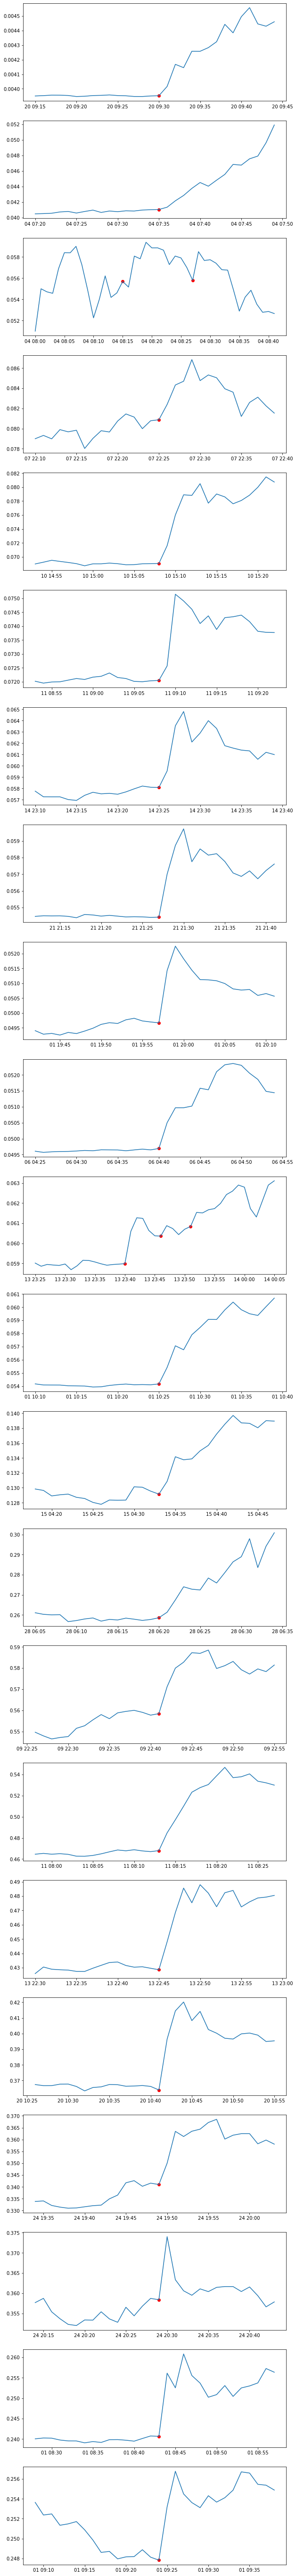

In [60]:
# Because we want to analyze the crypto market performance before and after Musk's tweet, we need to identify the time before and after Musk's tweet
# Then, we respectively split price change data, volume data and volatility into two lists, and see whether there is a significant difference between them
price_change_before_twitter_list = []
price_change_after_twitter_list = []
volume_before_twitter_list = []
volume_after_twitter_list = []
volatility_before_twitter_list = []
volatility_after_twitter_list = []
max_price_change_before_twitter_list = []
max_price_change_after_twitter_list = []
plt.figure(figsize=(10,100))
names = locals()
for count,index in enumerate(timestamp_gap_index):
    if count!=0:
        dfm_temp = merge_df.loc[timestamp_gap_index[count-1]:index-1]
    else:
        dfm_temp = merge_df.loc[0:index-1]
    # Analysis
    # Find the first tweet index 
    first_tweet_index = dfm_temp[dfm_temp['tweet']==True].index[0]
    # Find the last tweet index
    last_tweet_index = dfm_temp[dfm_temp['tweet']==True].index[-1]

    # Find the first price change before the first tweet
    price_change_before_twitter = list(dfm_temp.loc[dfm_temp.index[0]:first_tweet_index]['price_change'])
    price_change_before_twitter_list.extend(price_change_before_twitter)
    # Find the last price change after the last tweet
    price_change_after_twitter = list(dfm_temp.loc[last_tweet_index:]['price_change'])
    price_change_after_twitter_list.extend(price_change_after_twitter)

    # Find the first volume before the first tweet
    volume_before_twitter_list.extend(list(dfm_temp.loc[dfm_temp.index[0]:first_tweet_index]['volume']))
    # Find the last volume after the last tweet
    volume_after_twitter_list.extend(list(dfm_temp.loc[last_tweet_index:]['volume']))

    # Find the first volatility before the first tweet
    volatility_before_twitter_list.append(dfm_temp.loc[dfm_temp.index[0]:first_tweet_index]['price_change'].std())
    # Find the last volatility after the last tweet
    volatility_after_twitter_list.append(dfm_temp.loc[last_tweet_index:]['price_change'].std()) 
    
    # Find the max price change before the first tweet
    max_price_change_before_twitter_list.extend(dfm_temp.loc[dfm_temp.index[0]:first_tweet_index]['max_price_change'])
    # Find the max price change after the last tweet
    max_price_change_after_twitter_list.extend(dfm_temp.loc[last_tweet_index:]['max_price_change'])
    names[f"ax{count}"] = plt.subplot(len(timestamp_gap_index),1,count+1)
    names[f"ax{count}"].plot(dfm_temp["timestamp"],dfm_temp["open"])
    dfm_tweets_temp = dfm_temp[dfm_temp["tweet_content"].notna()]
    names[f"ax{count}"].scatter(dfm_tweets_temp["timestamp"],dfm_tweets_temp["open"],color="red") 

/tmp/ipykernel_28573/499255652.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['','before','after',''])
/tmp/ipykernel_28573/499255652.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['','before','after',''])
/tmp/ipykernel_28573/499255652.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(['','before','after',''])
/tmp/ipykernel_28573/499255652.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_yticklabels(['','before','after',''])


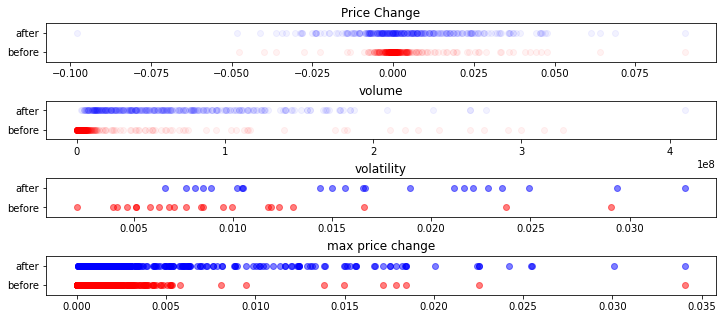

In [61]:
# Draw the scatter plot to see the difference
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(4,1,1)
ax2 = fig.add_subplot(4,1,2)
ax3 = fig.add_subplot(4,1,3)
ax4 = fig.add_subplot(4,1,4)

# draw the scatter plot of price change
ax1.set_title('Price Change')
ax1.set_ylim(-0.5,1.5,1)
ax1.set_yticklabels(['','before','after',''])
ax1.scatter(price_change_before_twitter_list, [0]*len(price_change_before_twitter_list), marker='o', color='r', alpha=0.05)
ax1.scatter(price_change_after_twitter_list, [1]*len(price_change_after_twitter_list), marker='o', color='b', alpha=0.05)

ax2.set_title('volume')
ax2.set_ylim(-0.5,1.5,1)
ax2.set_yticklabels(['','before','after',''])
ax2.scatter(volume_before_twitter_list, [0]*len(volume_before_twitter_list), marker='o', color='r', alpha=0.05)
ax2.scatter(volume_after_twitter_list, [1]*len(volume_after_twitter_list), marker='o', color='b', alpha=0.05)

ax3.set_title('volatility')
ax3.set_ylim(-0.5,1.5,1)
ax3.set_yticklabels(['','before','after',''])
ax3.scatter(volatility_before_twitter_list, [0]*len(volatility_before_twitter_list), marker='o', color='r', alpha=0.5)
ax3.scatter(volatility_after_twitter_list, [1]*len(volatility_after_twitter_list), marker='o', color='b', alpha=0.5)

ax4.set_title('max price change')
ax4.set_ylim(-0.5,1.5,1)
ax4.set_yticklabels(['','before','after',''])
ax4.scatter(max_price_change_before_twitter_list, [0]*len(max_price_change_before_twitter_list), marker='o', color='r', alpha=0.5)
ax4.scatter(max_price_change_after_twitter_list, [1]*len(max_price_change_after_twitter_list), marker='o', color='b', alpha=0.5)

# plt.yticks([0,1],['before','after'])
plt.subplots_adjust(hspace=1)
plt.show()

### Hypothesis 1
The price change before and after the first tweet is significantly different

([<matplotlib.axis.XTick at 0x7f14981e1bb0>,
 [Text(1, 0, 'before'), Text(2, 0, 'after')])

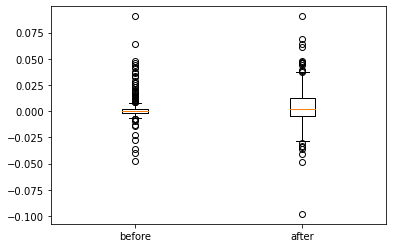

In [62]:
## Draw the picture of price change
# dropna
price_change_before_twitter_list = np.array(price_change_before_twitter_list)
price_change_before_twitter_list = price_change_before_twitter_list[~np.isnan(price_change_before_twitter_list)].tolist()
price_change_after_twitter_list = np.array(price_change_after_twitter_list)
price_change_after_twitter_list = price_change_after_twitter_list[~np.isnan(price_change_after_twitter_list)].tolist()
# draw the boxplot
plt.boxplot([price_change_before_twitter_list,price_change_after_twitter_list])
# rename the xtick
plt.xticks([1,2],['before','after'])

In [63]:
## Do the test
X =np.array([0]*len(price_change_before_twitter_list)+[1]*len(price_change_after_twitter_list)).astype("int")
Y = np.array(price_change_before_twitter_list+price_change_after_twitter_list).astype('float64')
dfm_price_change = pd.DataFrame({'X':X, 'Y':Y})
dfm_price_change.dropna(inplace=True)
X = dfm_price_change["X"]
Y = dfm_price_change["Y"]
# print(X,Y)
X = sm.add_constant(X)
lm = sm.OLS(Y,X).fit()
print (lm.summary()) 

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.063
Date:                Sun, 14 Nov 2021   Prob (F-statistic):             0.0442
Time:                        23:06:41   Log-Likelihood:                 1837.6
No. Observations:                 661   AIC:                            -3671.
Df Residuals:                     659   BIC:                            -3662.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.597      0.0

([<matplotlib.axis.XTick at 0x7f149aab06d0>,
 [Text(1, 0, 'before'), Text(2, 0, 'after')])

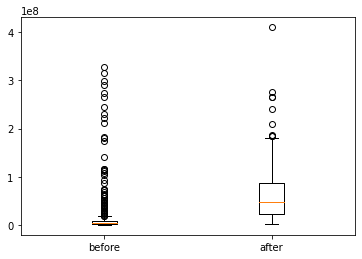

In [64]:
# Draw the picture of volume
# dropna
volume_before_twitter_list = np.array(volume_before_twitter_list)
volume_before_twitter_list = volume_before_twitter_list[~np.isnan(volume_before_twitter_list)].tolist()
volume_after_twitter_list = np.array(volume_after_twitter_list)
volume_after_twitter_list = volume_after_twitter_list[~np.isnan(volume_after_twitter_list)].tolist()
# draw the boxplot
plt.boxplot([volume_before_twitter_list,volume_after_twitter_list])
# rename the xtick
plt.xticks([1,2],['before','after'])


In [65]:
## Do the test
X =np.array([0]*len(volume_before_twitter_list)+[1]*len(volume_after_twitter_list)).astype("int")
Y = np.array(volume_before_twitter_list+volume_after_twitter_list).astype('float64')
dfm_volume = pd.DataFrame({'X':X, 'Y':Y})
dfm_volume.dropna(inplace=True)
X = dfm_volume["X"]
Y = dfm_volume["Y"]
# print(X,Y)
X = sm.add_constant(X)
lm = sm.OLS(Y,X).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     118.2
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           1.68e-25
Time:                        23:06:41   Log-Likelihood:                -13083.
No. Observations:                 682   AIC:                         2.617e+04
Df Residuals:                     680   BIC:                         2.618e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.928e+07   2.77e+06      6.965      0.0

([<matplotlib.axis.XTick at 0x7f14982b5ee0>,
 [Text(1, 0, 'before'), Text(2, 0, 'after')])

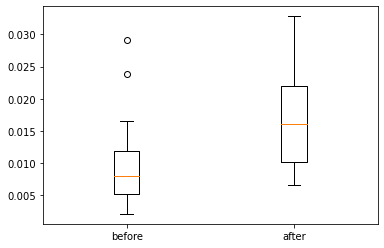

In [66]:
# Draw the picture of volatility
# dropna
volatility_before_twitter_list = np.array(volatility_before_twitter_list)
volatility_before_twitter_list = volatility_before_twitter_list[~np.isnan(volatility_before_twitter_list)].tolist()
volatility_after_twitter_list = np.array(volatility_after_twitter_list)
volatility_after_twitter_list = volatility_after_twitter_list[~np.isnan(volatility_after_twitter_list)].tolist()
# draw the boxplot
plt.boxplot([volatility_before_twitter_list,volatility_after_twitter_list])
# rename the xtick
plt.xticks([1,2],['before','after'])


In [67]:
## Do the test
X =np.array([0]*len(volatility_before_twitter_list)+[1]*len(volatility_after_twitter_list)).astype("int")
Y = np.array(volatility_before_twitter_list+volatility_after_twitter_list).astype('float64')
dfm_volatility = pd.DataFrame({'X':X, 'Y':Y})
dfm_volatility.dropna(inplace=True)
X = dfm_volatility["X"]
Y = dfm_volatility["Y"]
# print(X,Y)
X = sm.add_constant(X)
lm = sm.OLS(Y,X).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     10.86
Date:                Sun, 14 Nov 2021   Prob (F-statistic):            0.00200
Time:                        23:06:41   Log-Likelihood:                 156.98
No. Observations:                  44   AIC:                            -310.0
Df Residuals:                      42   BIC:                            -306.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0097      0.001      6.519      0.0

([<matplotlib.axis.XTick at 0x7f14982b5400>,
 [Text(1, 0, 'before'), Text(2, 0, 'after')])

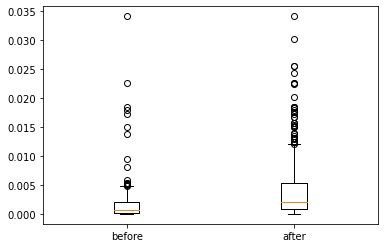

In [68]:
# Draw the picture of max price change
# dropna
max_price_change_before_twitter_list = np.array(max_price_change_before_twitter_list)
max_price_change_before_twitter_list = max_price_change_before_twitter_list[~np.isnan(max_price_change_before_twitter_list)].tolist()
max_price_change_after_twitter_list = np.array(max_price_change_after_twitter_list)
max_price_change_after_twitter_list = max_price_change_after_twitter_list[~np.isnan(max_price_change_after_twitter_list)].tolist()
# draw the boxplot
plt.boxplot([max_price_change_before_twitter_list,max_price_change_after_twitter_list])
# rename the xtick
plt.xticks([1,2],['before','after'])


In [69]:
## Do the test
X =np.array([0]*len(max_price_change_before_twitter_list)+[1]*len(max_price_change_after_twitter_list)).astype("int")
Y = np.array(max_price_change_before_twitter_list+max_price_change_after_twitter_list).astype('float64')
dfm_max_price_change = pd.DataFrame({'X':X, 'Y':Y})
dfm_max_price_change.dropna(inplace=True)
X = dfm_max_price_change["X"]
Y = dfm_max_price_change["Y"]
# print(X,Y)
X = sm.add_constant(X)
lm = sm.OLS(Y,X).fit()
print (lm.summary())


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     63.64
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           6.36e-15
Time:                        23:06:41   Log-Likelihood:                 2718.3
No. Observations:                 682   AIC:                            -5433.
Df Residuals:                     680   BIC:                            -5424.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      6.728      0.0

In [71]:
# save the cleaned data
merge_df.to_csv('cleaned_price_data.csv',index=False)

# Analyze the whether Musk tweets about Dogecoin heavily impacts the Google search trends
# # Get google trends data 

In [79]:
pytrend = TrendReq()
pytrend.build_payload(kw_list = ["doge"],timeframe='2020-12-01 2021-07-31')
trends = pytrend.interest_over_time()
trendsdf_part1 = pd.DataFrame(data = {'date': trends.index.tolist(),
                                'search': trends["doge"].tolist()})
pytrend.build_payload(kw_list = ["doge"],timeframe='2021-08-01 2021-12-31')
trends = pytrend.interest_over_time()
trendsdf_part2 = pd.DataFrame(data = {'date': trends.index.tolist(),
                                'search': trends["doge"].tolist()})
trendsdf = trendsdf_part1.append(trendsdf_part2)
trendsdf['date'] = pd.to_datetime(trendsdf['date']).dt.date
tweets_df["timestamp"] = pd.to_datetime(tweets_df["timestamp"]).dt.date
merged_dfm = pd.merge(left=trendsdf, right=tweets_df, how='outer', left_on='date',right_on='timestamp')
merged_dfm.sort_values(by='date', inplace=True)


## Preprocess data

In [80]:
day_lag = 4
merged_dfm["latest_date_of_tweets"] = merged_dfm["timestamp"].fillna(method="ffill")
merged_dfm["diff_dates"] = merged_dfm["date"]-merged_dfm["latest_date_of_tweets"]
merged_dfm[f"in_{day_lag}_days"] = merged_dfm["diff_dates"].apply(lambda x:0 if x>timedelta(day_lag) else 1)

X = merged_dfm[f"in_{day_lag}_days"]
Y = merged_dfm["search"]

## Analyze the data

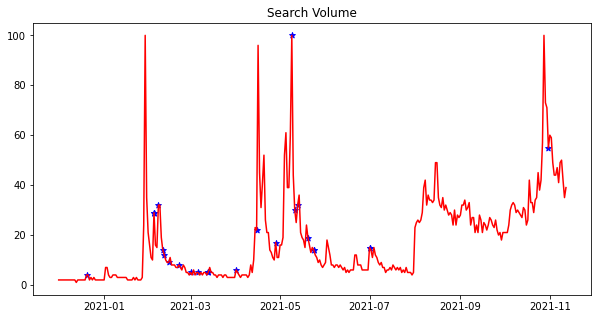

In [81]:
# plt search scatter 
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_title('Search Volume')
ax.plot(merged_dfm["date"],merged_dfm["search"], color='r')
ax.scatter(merged_dfm.dropna()["date"],merged_dfm.dropna()["search"], marker='*', color='b')

In [82]:
# Hypothesis 1:
# There is a significant change if in google search Elon Musk talked about dogecoin in the tweets that day
day_lag = 0
merged_dfm[f"in_{day_lag}_days"] = merged_dfm["diff_dates"].apply(lambda x:0 if x>timedelta(day_lag) else 1)

X = merged_dfm[f"in_{day_lag}_days"]
Y = merged_dfm["search"]
# print(X,Y)f"in_{day_lag}_days"
X = sm.add_constant(X)
lm = sm.OLS(Y,X).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 search   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.189
Date:                Sun, 14 Nov 2021   Prob (F-statistic):             0.0414
Time:                        23:15:13   Log-Likelihood:                -1500.2
No. Observations:                 353   AIC:                             3004.
Df Residuals:                     351   BIC:                             3012.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.1558      0.969     18.733      0.0

In [83]:
# Hypothesis 2:
# There is a significant change in google search if Elon Musk talked about dogecoin in the tweets in last 4 days
day_lag = 4
merged_dfm[f"in_{day_lag}_days"] = merged_dfm["diff_dates"].apply(lambda x:0 if x>timedelta(day_lag) else 1)

X = merged_dfm[f"in_{day_lag}_days"]
Y = merged_dfm["search"]
# print(X,Y)f"in_{day_lag}_days"
X = sm.add_constant(X)
lm = sm.OLS(Y,X).fit()
print (lm.summary())

                            OLS Regression Results                            
Dep. Variable:                 search   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.830
Date:                Sun, 14 Nov 2021   Prob (F-statistic):             0.0511
Time:                        23:15:14   Log-Likelihood:                -1500.4
No. Observations:                 353   AIC:                             3005.
Df Residuals:                     351   BIC:                             3013.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.6245      1.087     17.130      0.0

In [84]:
# save the cleaned data
merged_dfm.to_csv('cleaned_trend_data.csv',index=False)